In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import boto3
import io
from collections import defaultdict
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Set style
plt.style.use('default')
sns.set_palette("husl")

# Load the data
df = pd.read_csv('significant_model_results.csv')
# Convert Significant column to boolean if it's string
if df['Significant'].dtype == 'object':
    df['Significant'] = df['Significant'].astype(str).str.lower() == 'true'

print("Data Overview:")
print(f"Shape: {df.shape}")
print(f"Outcomes: {df['Outcome'].unique()}")
print(f"Variables: {df['Variable'].unique()}")
print(f"All significant: {df['Significant'].all()}")



Data Overview:
Shape: (14, 7)
Outcomes: ['Children_NoMarriage_w23' 'CnctAdult_w23' 'Connected_Youth'
 'Homeless_w23' 'Incarc_w23' 'SubAbuse_w23']
Variables: ['White_Only' 'CnctAdult_w1' 'PlacementInstability' 'Sex' 'DiagDis'
 'MonthsInCare']
All significant: True


In [4]:
# Cell 2: Data Preparation and Summary Statistics
# Calculate confidence interval width and effect size categories
df['CI_Width'] = df['CI Upper'] - df['CI Lower']
df['Abs_Coefficient'] = abs(df['Coefficient'])
df['Effect_Size'] = pd.cut(df['Abs_Coefficient'], 
                          bins=[0, 0.2, 0.5, 1.0, float('inf')], 
                          labels=['Small', 'Medium', 'Large', 'Very Large'])

# Create significance categories based on p-values
df['Significance_Level'] = pd.cut(df['P-Value'], 
                                 bins=[0, 0.001, 0.01, 0.05, 1.0],
                                 labels=['p<0.001', '0.001≤p<0.01', '0.01≤p<0.05', 'p≥0.05'])

# Summary statistics
print("\nSummary Statistics:")
print(df[['Coefficient', 'P-Value', 'CI_Width']].describe())
print(f"\nEffect Size Distribution:")
print(df['Effect_Size'].value_counts())


Summary Statistics:
       Coefficient    P-Value   CI_Width
count    19.000000  19.000000  19.000000
mean      0.008631   0.015234   1.274729
std       1.301047   0.015096   1.489472
min      -3.329700   0.000004   0.034534
25%      -0.281545   0.002255   0.112895
50%       0.055149   0.010813   0.887342
75%       0.776140   0.024800   1.316801
max       2.401497   0.048087   4.762569

Effect Size Distribution:
Very Large    8
Small         7
Large         3
Medium        1
Name: Effect_Size, dtype: int64


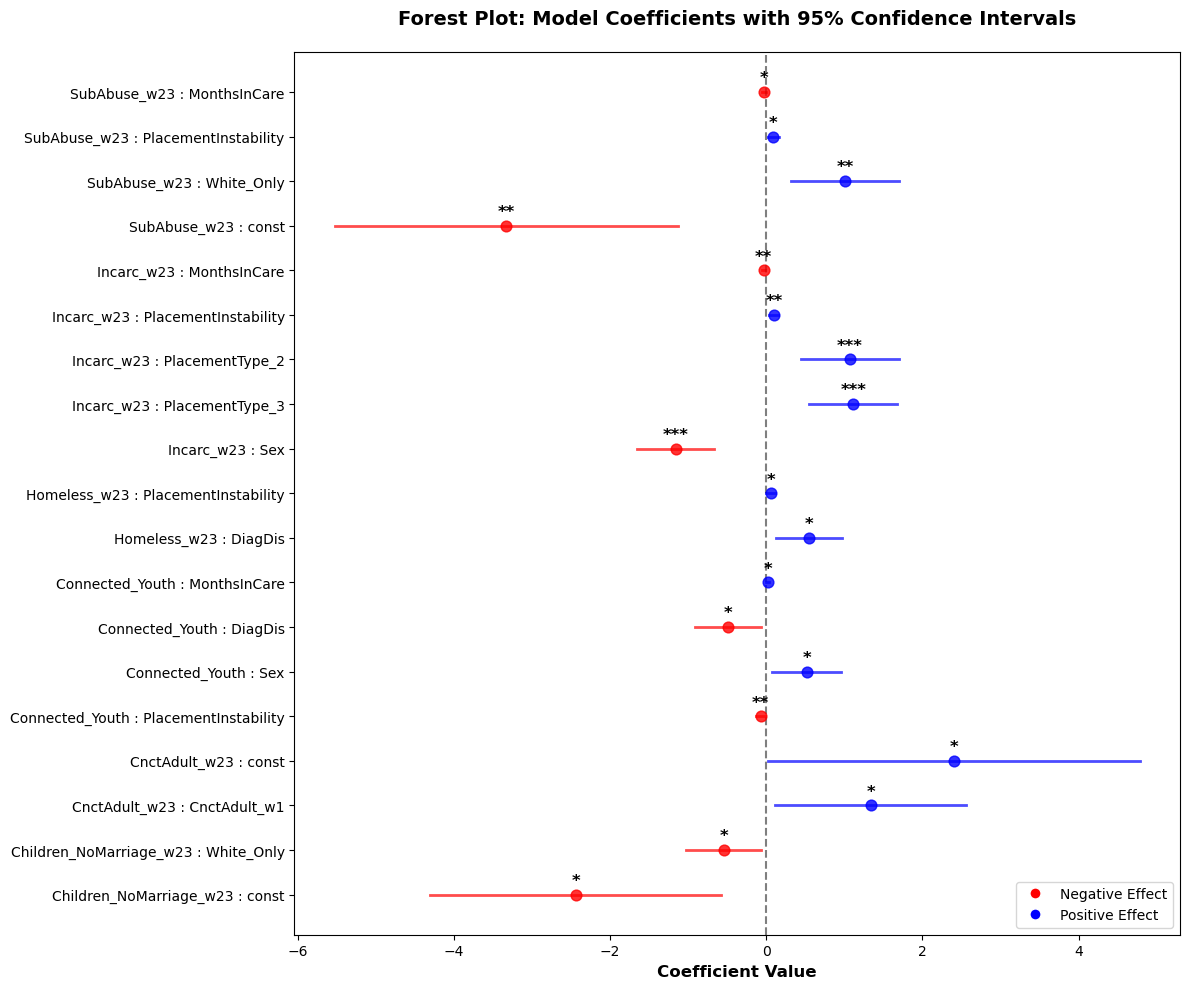

In [5]:
# Cell 3: Forest Plot - Coefficients with Confidence Intervals
fig, ax = plt.subplots(figsize=(12, 10))

# Create labels combining outcome and variable
df['Label'] = df['Outcome'] + ' : ' + df['Variable']
y_positions = range(len(df))

# Plot confidence intervals
for i, (idx, row) in enumerate(df.iterrows()):
    color = 'red' if row['Coefficient'] < 0 else 'blue'
    
    # Plot confidence interval line
    ax.plot([row['CI Lower'], row['CI Upper']], [i, i], 
            color=color, linewidth=2, alpha=0.7)
    
    # Plot coefficient point
    ax.scatter(row['Coefficient'], i, 
              color=color, s=60, zorder=5, alpha=0.8)
    # Add p-value annotation
    if row['P-Value'] < 0.001:
        p_text = '***'
    elif row['P-Value'] < 0.01:
        p_text = '**'
    elif row['P-Value'] < 0.05:
        p_text = '*'
    else:
        p_text = ''
    
    ax.text(row['Coefficient'], i + 0.15, p_text, 
            ha='center', va='bottom', fontweight='bold', fontsize=12)

# Add vertical line at zero
ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)

# Customize plot
ax.set_yticks(y_positions)
ax.set_yticklabels(df['Label'], fontsize=10)
ax.set_xlabel('Coefficient Value', fontsize=12, fontweight='bold')
ax.set_title('Forest Plot: Model Coefficients with 95% Confidence Intervals', 
             fontsize=14, fontweight='bold', pad=20)
# Add legend
red_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                       markersize=8, label='Negative Effect')
blue_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
                        markersize=8, label='Positive Effect')
ax.legend(handles=[red_patch, blue_patch], loc='lower right')

plt.tight_layout()
plt.show()
    

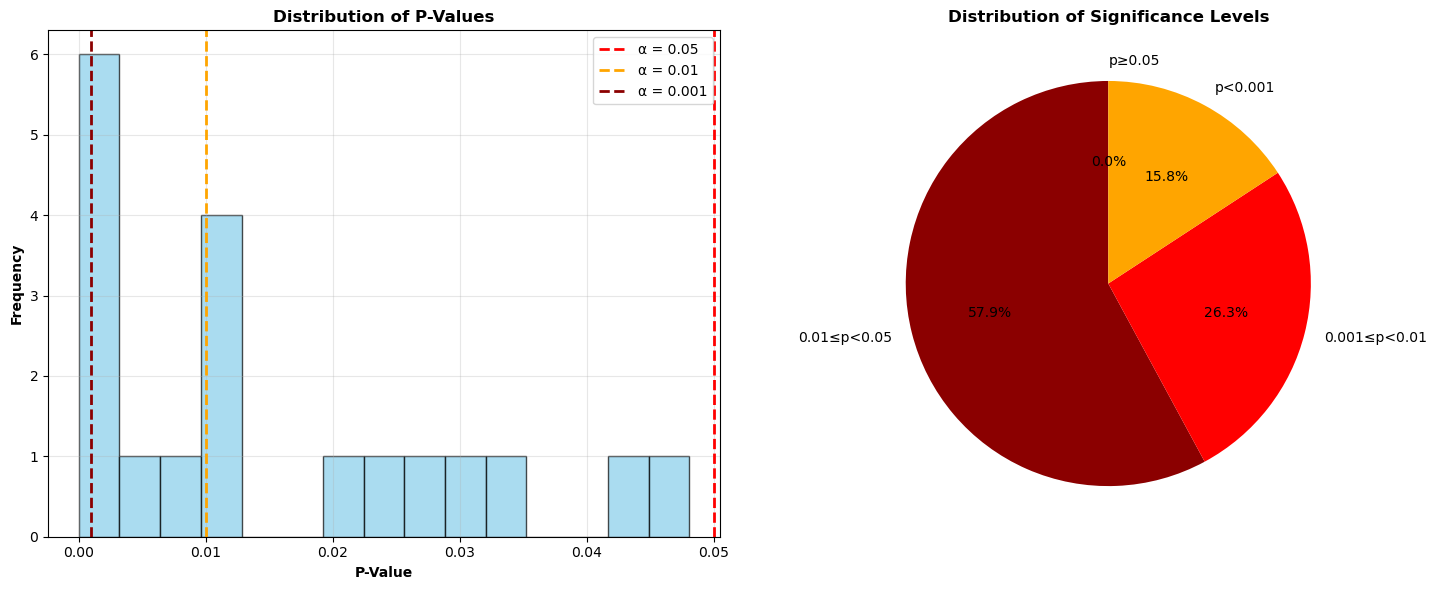

In [6]:
# Cell 4: P-Value Distribution and Significance Levels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# P-value histogram
ax1.hist(df['P-Value'], bins=15, alpha=0.7, color='skyblue', edgecolor='black')
ax1.axvline(x=0.05, color='red', linestyle='--', linewidth=2, label='α = 0.05')
ax1.axvline(x=0.01, color='orange', linestyle='--', linewidth=2, label='α = 0.01')
ax1.axvline(x=0.001, color='darkred', linestyle='--', linewidth=2, label='α = 0.001')
ax1.set_xlabel('P-Value', fontweight='bold')
ax1.set_ylabel('Frequency', fontweight='bold')
ax1.set_title('Distribution of P-Values', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Significance level pie chart
sig_counts = df['Significance_Level'].value_counts()
colors = ['darkred', 'red', 'orange', 'lightgray']
ax2.pie(sig_counts.values, labels=sig_counts.index, autopct='%1.1f%%', 
        colors=colors[:len(sig_counts)], startangle=90)
ax2.set_title('Distribution of Significance Levels', fontweight='bold')

plt.tight_layout()
plt.show()

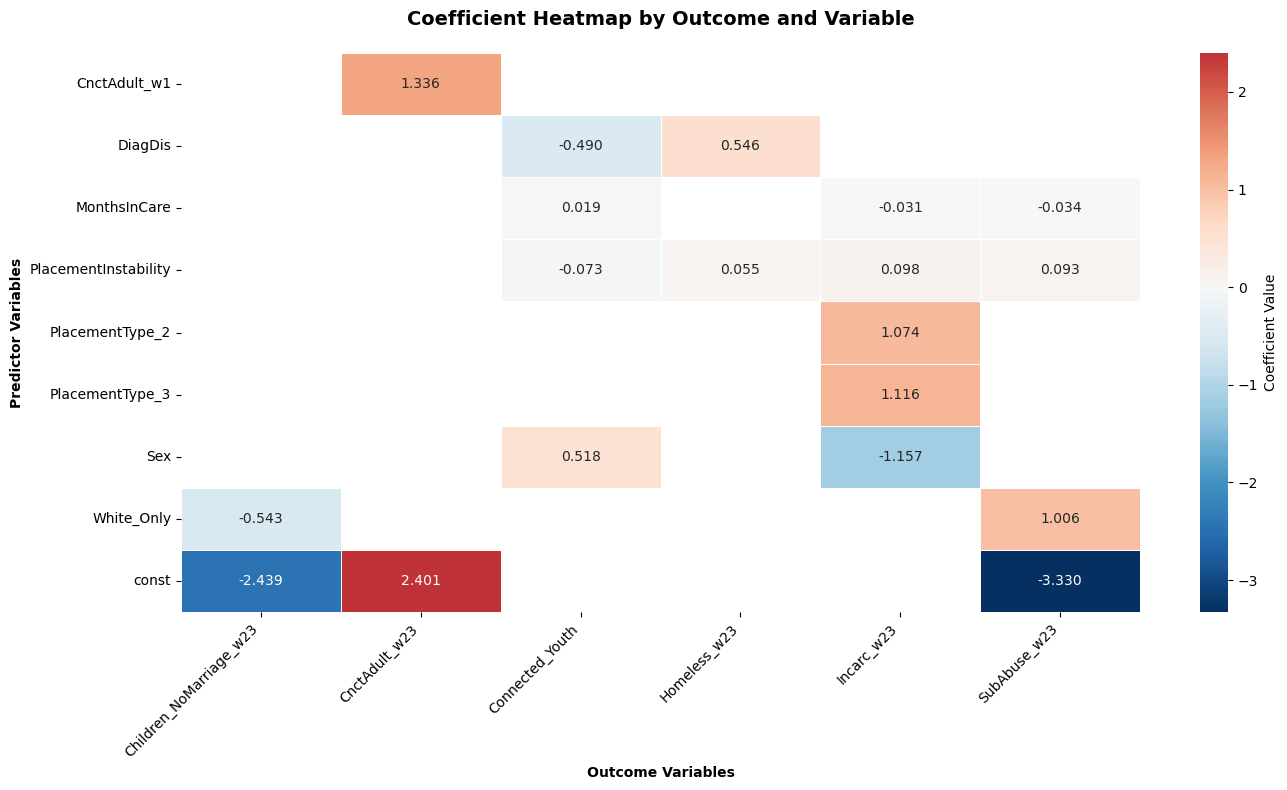

In [7]:
# Cell 5: Coefficient Magnitude Analysis by Outcome
# Create a heatmap of coefficient magnitudes
pivot_data = df.pivot(index='Variable', columns='Outcome', values='Coefficient')

fig, ax = plt.subplots(figsize=(14, 8))
mask = pivot_data.isnull()

# Create heatmap
sns.heatmap(pivot_data, 
            annot=True, 
            fmt='.3f', 
            cmap='RdBu_r', 
            center=0,
            mask=mask,
            cbar_kws={'label': 'Coefficient Value'},
            ax=ax,
            linewidths=0.5)

ax.set_title('Coefficient Heatmap by Outcome and Variable', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Outcome Variables', fontweight='bold')
ax.set_ylabel('Predictor Variables', fontweight='bold')

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

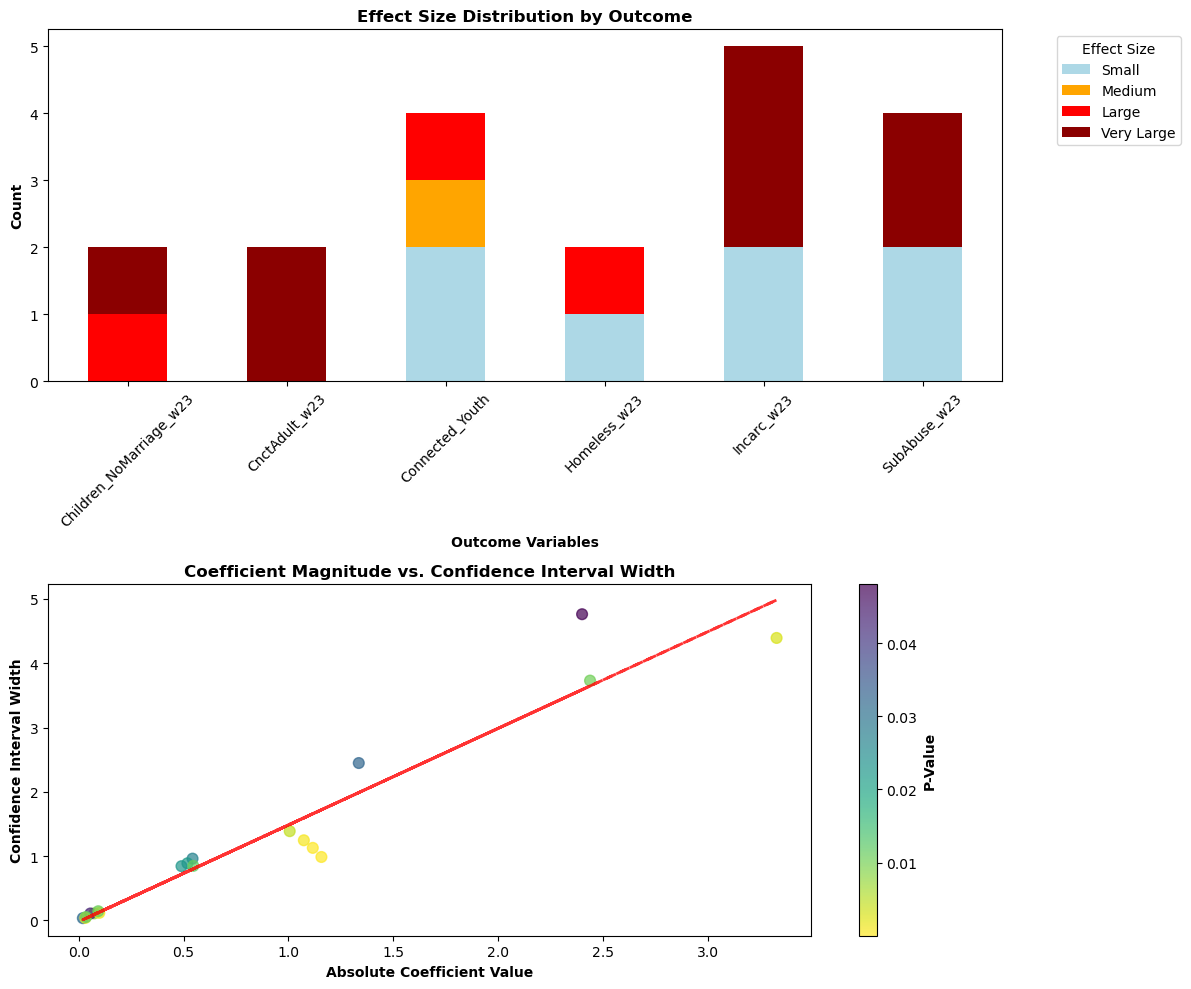

In [8]:
# Cell 6: Effect Size and Confidence Interval Analysis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Effect size distribution by outcome
effect_counts = df.groupby(['Outcome', 'Effect_Size']).size().unstack(fill_value=0)
effect_counts.plot(kind='bar', stacked=True, ax=ax1, 
                  color=['lightblue', 'orange', 'red', 'darkred'])
ax1.set_title('Effect Size Distribution by Outcome', fontweight='bold')
ax1.set_xlabel('Outcome Variables', fontweight='bold')
ax1.set_ylabel('Count', fontweight='bold')
ax1.legend(title='Effect Size', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.tick_params(axis='x', rotation=45)

# Confidence interval width vs coefficient magnitude
scatter = ax2.scatter(df['Abs_Coefficient'], df['CI_Width'], 
                     c=df['P-Value'], cmap='viridis_r', 
                     alpha=0.7, s=60)
ax2.set_xlabel('Absolute Coefficient Value', fontweight='bold')
ax2.set_ylabel('Confidence Interval Width', fontweight='bold')
ax2.set_title('Coefficient Magnitude vs. Confidence Interval Width', fontweight='bold')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('P-Value', fontweight='bold')
# Add trend line
z = np.polyfit(df['Abs_Coefficient'], df['CI_Width'], 1)
p = np.poly1d(z)
ax2.plot(df['Abs_Coefficient'], p(df['Abs_Coefficient']), 
         "r--", alpha=0.8, linewidth=2)

plt.tight_layout()
plt.show()

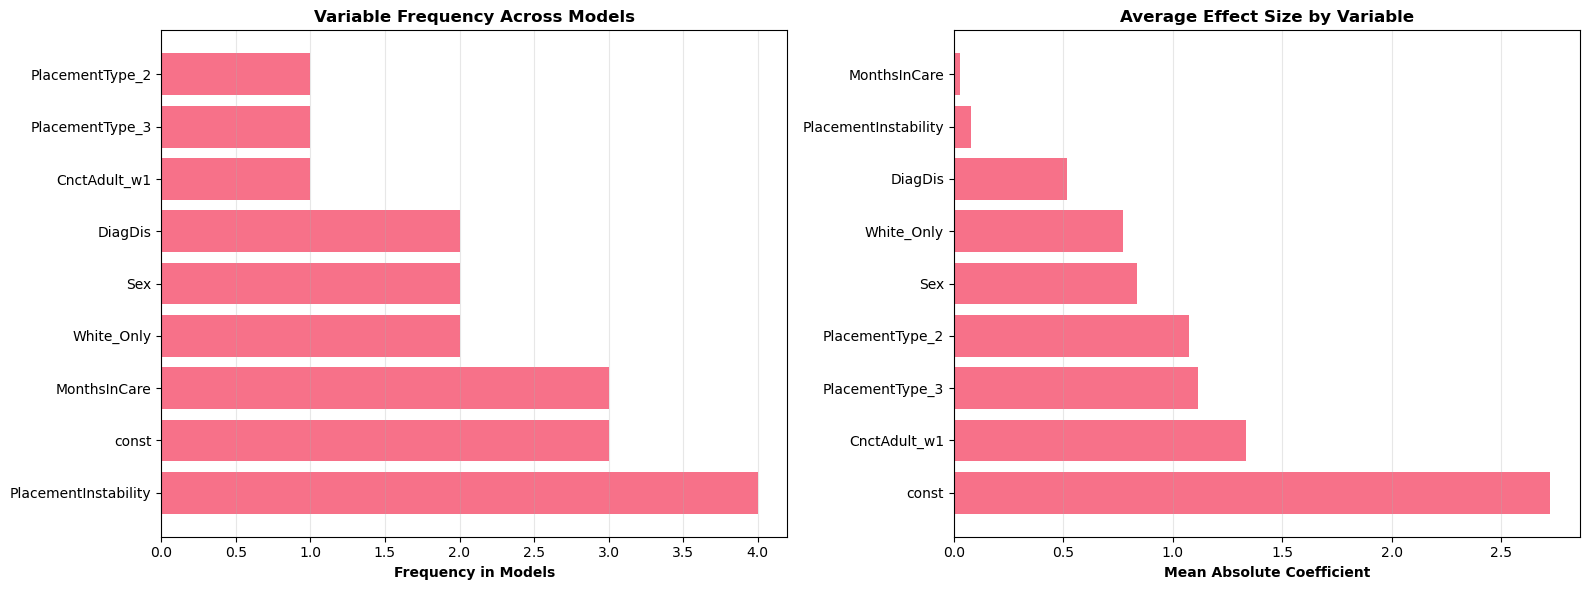


Variable Summary Statistics:
                      Frequency  Mean_Coeff  Std_Coeff  Mean_Abs_Coeff  \
Variable                                                                 
const                         3     -1.1226     3.0842          2.7236   
CnctAdult_w1                  1      1.3358        NaN          1.3358   
PlacementType_3               1      1.1163        NaN          1.1163   
PlacementType_2               1      1.0737        NaN          1.0737   
Sex                           2     -0.3197     1.1848          0.8378   
White_Only                    2      0.2318     1.0951          0.7744   
DiagDis                       2      0.0282     0.7325          0.5179   
PlacementInstability          4      0.0430     0.0798          0.0796   
MonthsInCare                  3     -0.0155     0.0299          0.0282   

                      Mean_P_Value  
Variable                            
const                       0.0205  
CnctAdult_w1                0.0324  
Placeme

In [9]:
 #Cell 7: Variable Importance Analysis
# Count how many times each variable appears and calculate average effect size
var_summary = df.groupby('Variable').agg({
    'Coefficient': ['count', 'mean', 'std'],
    'Abs_Coefficient': 'mean',
    'P-Value': 'mean'
}).round(4)

var_summary.columns = ['Frequency', 'Mean_Coeff', 'Std_Coeff', 'Mean_Abs_Coeff', 'Mean_P_Value']
var_summary = var_summary.sort_values('Mean_Abs_Coeff', ascending=False)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Variable frequency
var_freq = df['Variable'].value_counts()
ax1.barh(range(len(var_freq)), var_freq.values)
ax1.set_yticks(range(len(var_freq)))
ax1.set_yticklabels(var_freq.index)
ax1.set_xlabel('Frequency in Models', fontweight='bold')
ax1.set_title('Variable Frequency Across Models', fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Average absolute effect size
ax2.barh(range(len(var_summary)), var_summary['Mean_Abs_Coeff'])
ax2.set_yticks(range(len(var_summary)))
ax2.set_yticklabels(var_summary.index)
ax2.set_xlabel('Mean Absolute Coefficient', fontweight='bold')
ax2.set_title('Average Effect Size by Variable', fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nVariable Summary Statistics:")
print(var_summary)

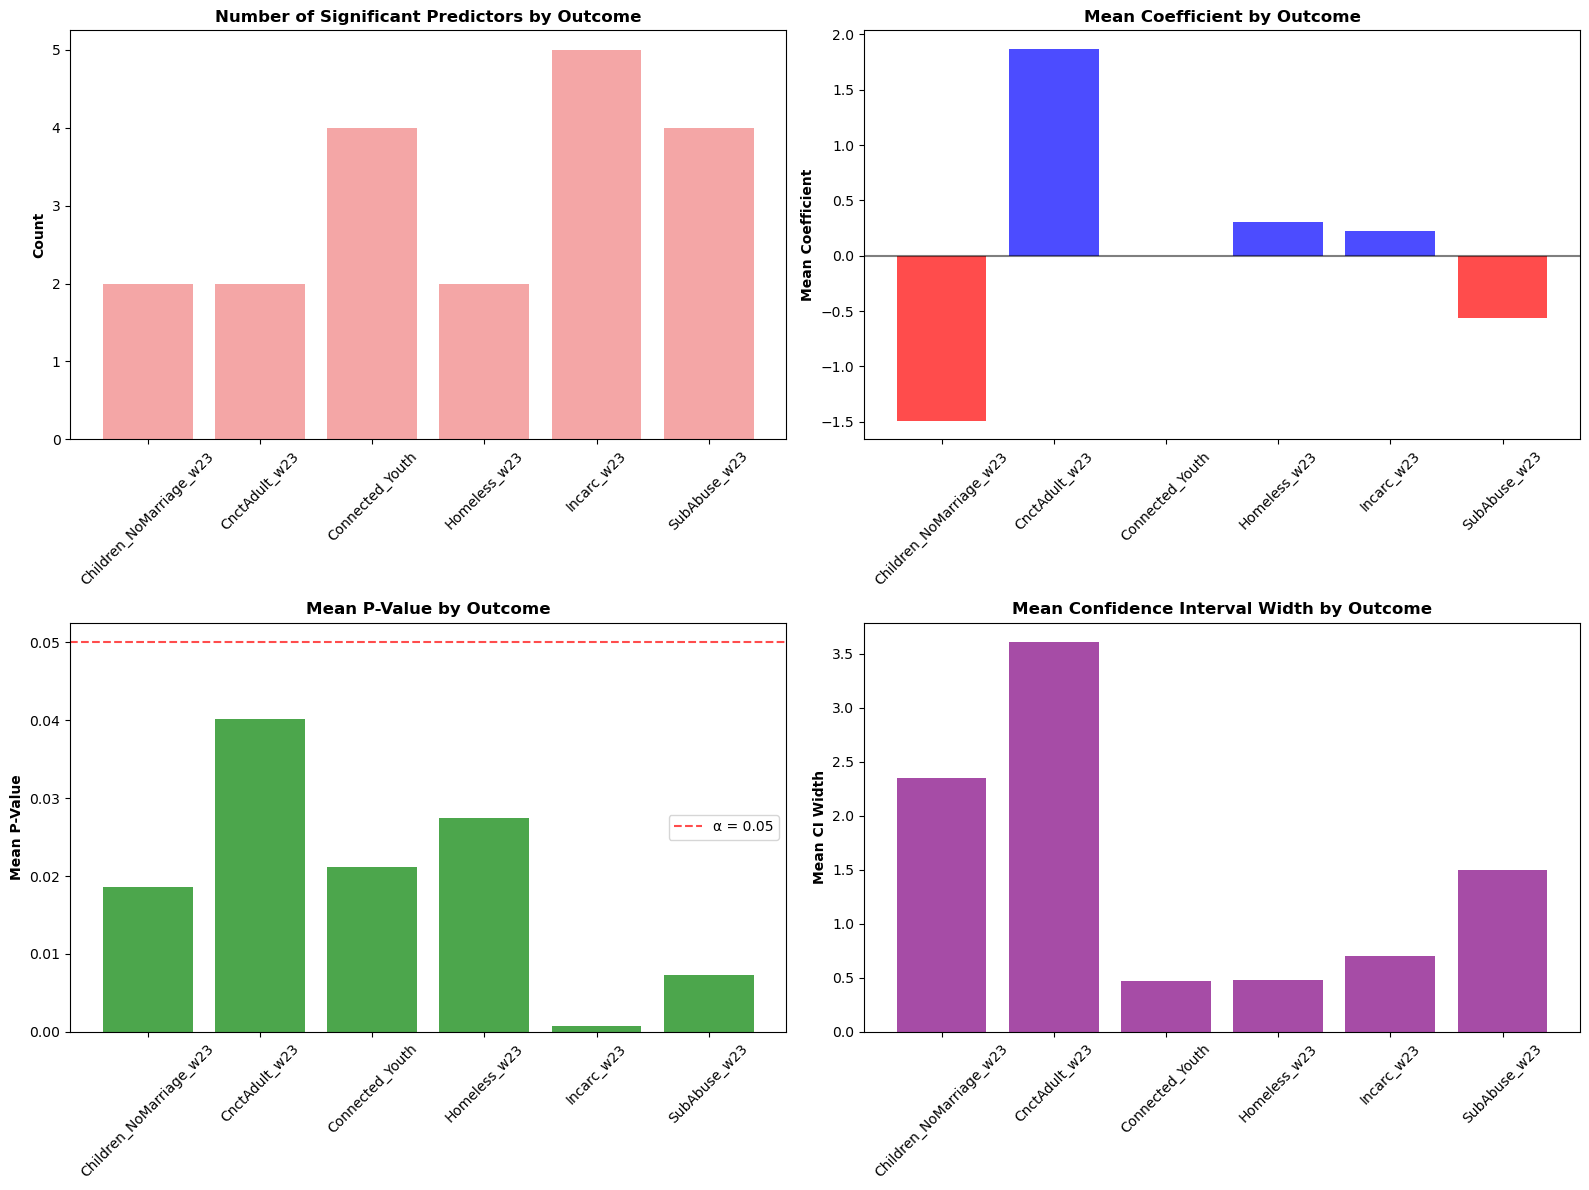


Outcome Summary Statistics:
                         N_Predictors  Mean_Coeff  Std_Coeff  Mean_P_Value  \
Outcome                                                                      
Children_NoMarriage_w23             2     -1.4910     1.3414        0.0186   
CnctAdult_w23                       2      1.8686     0.7536        0.0402   
Connected_Youth                     4     -0.0065     0.4139        0.0211   
Homeless_w23                        2      0.3006     0.3471        0.0274   
Incarc_w23                          5      0.2197     0.9364        0.0007   
SubAbuse_w23                        4     -0.5663     1.8997        0.0073   

                         Mean_CI_Width  
Outcome                                 
Children_NoMarriage_w23         2.3450  
CnctAdult_w23                   3.6050  
Connected_Youth                 0.4685  
Homeless_w23                    0.4773  
Incarc_w23                      0.7031  
SubAbuse_w23                    1.4940  


In [10]:
# Cell 8: Outcome-Specific Analysis
# Number of significant predictors per outcome
outcome_summary = df.groupby('Outcome').agg({
    'Variable': 'count',
    'Coefficient': ['mean', 'std'],
    'P-Value': 'mean',
    'CI_Width': 'mean'
}).round(4)

outcome_summary.columns = ['N_Predictors', 'Mean_Coeff', 'Std_Coeff', 'Mean_P_Value', 'Mean_CI_Width']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Number of predictors per outcome
ax1.bar(outcome_summary.index, outcome_summary['N_Predictors'], 
        color='lightcoral', alpha=0.7)
ax1.set_title('Number of Significant Predictors by Outcome', fontweight='bold')
ax1.set_ylabel('Count', fontweight='bold')
ax1.tick_params(axis='x', rotation=45)

# Mean coefficient by outcome
colors = ['red' if x < 0 else 'blue' for x in outcome_summary['Mean_Coeff']]
ax2.bar(outcome_summary.index, outcome_summary['Mean_Coeff'], 
        color=colors, alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax2.set_title('Mean Coefficient by Outcome', fontweight='bold')
ax2.set_ylabel('Mean Coefficient', fontweight='bold')
ax2.tick_params(axis='x', rotation=45)

# Mean p-value by outcome
ax3.bar(outcome_summary.index, outcome_summary['Mean_P_Value'], 
        color='green', alpha=0.7)
ax3.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='α = 0.05')
ax3.set_title('Mean P-Value by Outcome', fontweight='bold')
ax3.set_ylabel('Mean P-Value', fontweight='bold')
ax3.tick_params(axis='x', rotation=45)
ax3.legend()

# Mean CI width by outcome
ax4.bar(outcome_summary.index, outcome_summary['Mean_CI_Width'], 
        color='purple', alpha=0.7)
ax4.set_title('Mean Confidence Interval Width by Outcome', fontweight='bold')
ax4.set_ylabel('Mean CI Width', fontweight='bold')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\nOutcome Summary Statistics:")
print(outcome_summary)


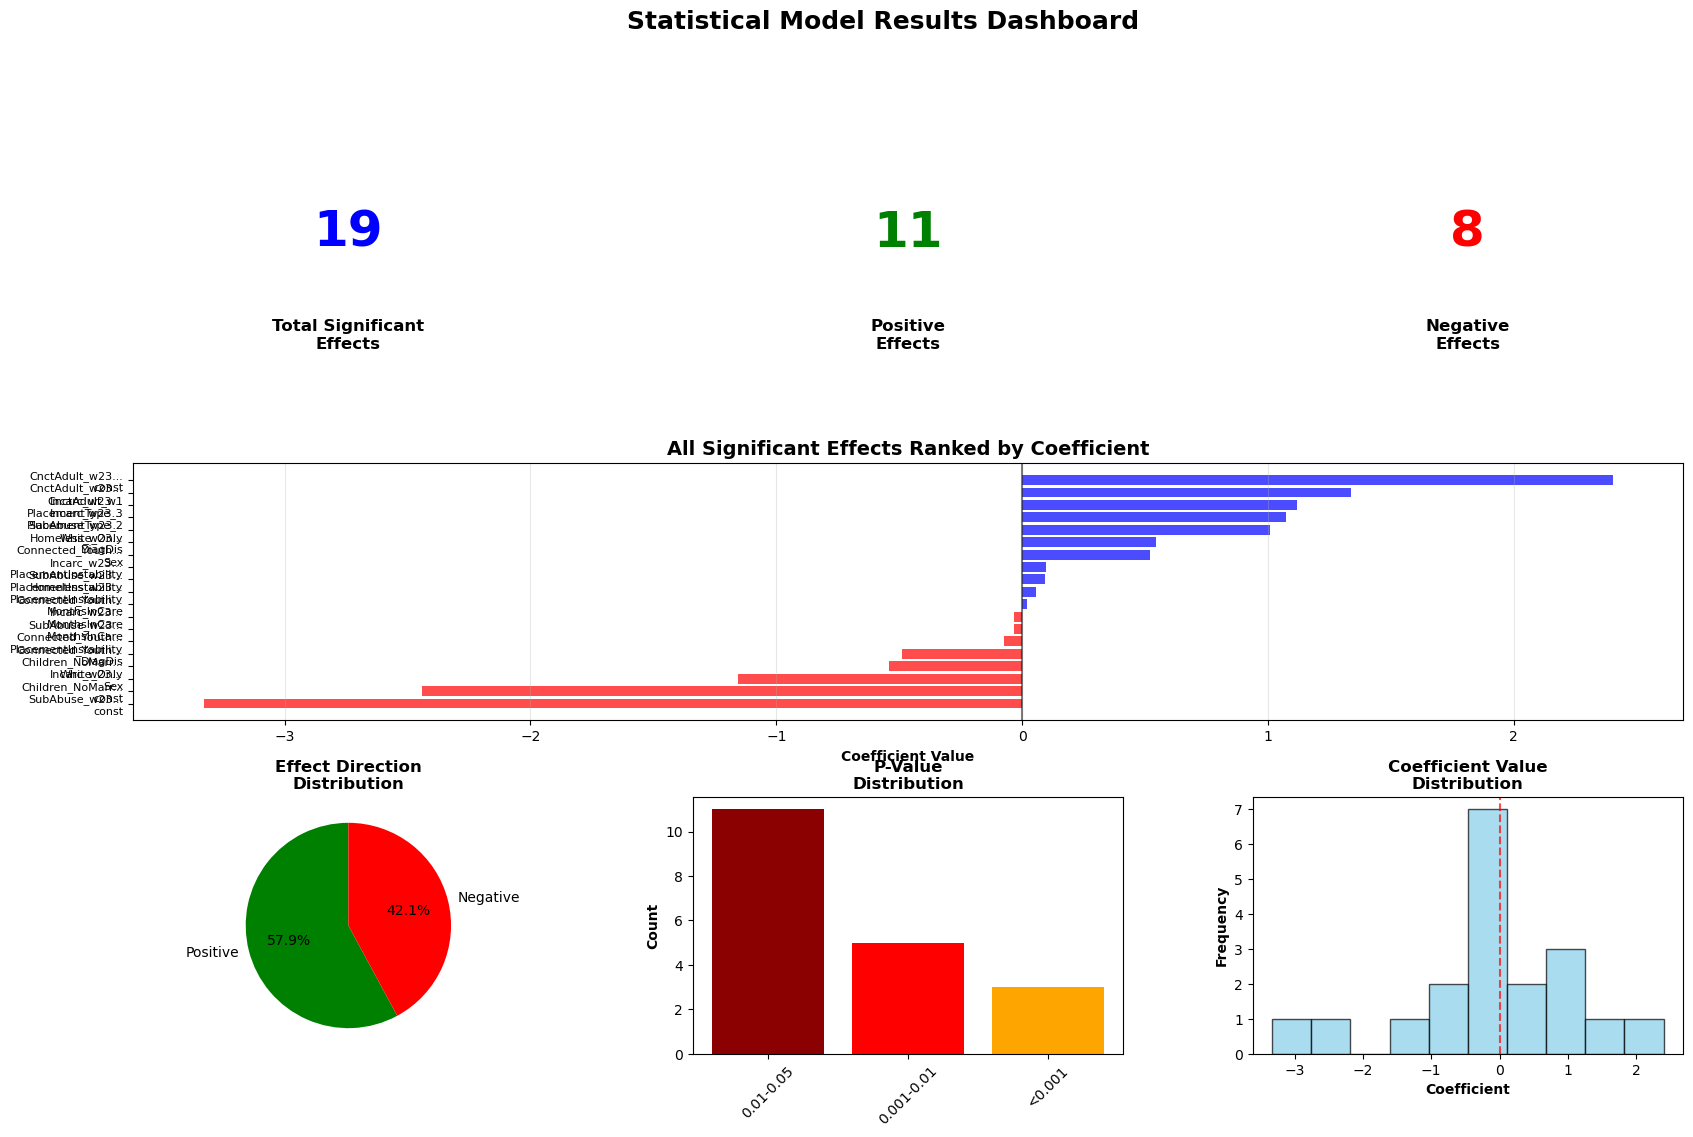

In [11]:
# Cell 9: Create Summary Dashboard
fig = plt.figure(figsize=(20, 12))

# Create a 3x3 grid
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Top row - Overview metrics
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

# Middle row - Main visualizations
ax4 = fig.add_subplot(gs[1, :])

# Bottom row - Additional insights
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])
ax7 = fig.add_subplot(gs[2, 2])

# Key metrics
total_effects = len(df)
positive_effects = (df['Coefficient'] > 0).sum()
negative_effects = (df['Coefficient'] < 0).sum()
mean_p_value = df['P-Value'].mean()

# Metric boxes
metrics = [
    ('Total Significant\nEffects', total_effects, 'blue'),
    ('Positive\nEffects', positive_effects, 'green'),
    ('Negative\nEffects', negative_effects, 'red')
]

for i, (ax, (label, value, color)) in enumerate(zip([ax1, ax2, ax3], metrics)):
    ax.text(0.5, 0.6, str(value), ha='center', va='center', 
            fontsize=36, fontweight='bold', color=color)
    ax.text(0.5, 0.2, label, ha='center', va='center', 
            fontsize=12, fontweight='bold')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
# Main coefficient plot
df_sorted = df.sort_values('Coefficient')
colors = ['red' if x < 0 else 'blue' for x in df_sorted['Coefficient']]
bars = ax4.barh(range(len(df_sorted)), df_sorted['Coefficient'], color=colors, alpha=0.7)
ax4.set_yticks(range(len(df_sorted)))
ax4.set_yticklabels([f"{row['Outcome'][:15]}...\n{row['Variable']}" for _, row in df_sorted.iterrows()], 
                    fontsize=8)
ax4.axvline(x=0, color='black', linestyle='-', alpha=0.5)
ax4.set_xlabel('Coefficient Value', fontweight='bold')
ax4.set_title('All Significant Effects Ranked by Coefficient', fontweight='bold', fontsize=14)
ax4.grid(axis='x', alpha=0.3)

# Effect direction pie chart
effect_direction = ['Positive' if x > 0 else 'Negative' for x in df['Coefficient']]
direction_counts = pd.Series(effect_direction).value_counts()
ax5.pie(direction_counts.values, labels=direction_counts.index, autopct='%1.1f%%',
        colors=['green', 'red'], startangle=90)
ax5.set_title('Effect Direction\nDistribution', fontweight='bold')

# P-value ranges
p_ranges = pd.cut(df['P-Value'], bins=[0, 0.001, 0.01, 0.05], 
                  labels=['<0.001', '0.001-0.01', '0.01-0.05'])
p_counts = p_ranges.value_counts()
ax6.bar(p_counts.index, p_counts.values, color=['darkred', 'red', 'orange'])
ax6.set_title('P-Value\nDistribution', fontweight='bold')
ax6.set_ylabel('Count', fontweight='bold')
ax6.tick_params(axis='x', rotation=45)

# Coefficient range distribution
ax7.hist(df['Coefficient'], bins=10, color='skyblue', alpha=0.7, edgecolor='black')
ax7.axvline(x=0, color='red', linestyle='--', alpha=0.7)
ax7.set_title('Coefficient Value\nDistribution', fontweight='bold')
ax7.set_xlabel('Coefficient', fontweight='bold')
ax7.set_ylabel('Frequency', fontweight='bold')

plt.suptitle('Statistical Model Results Dashboard', fontsize=18, fontweight='bold', y=0.98)
plt.show()

In [13]:
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

# Per Sig

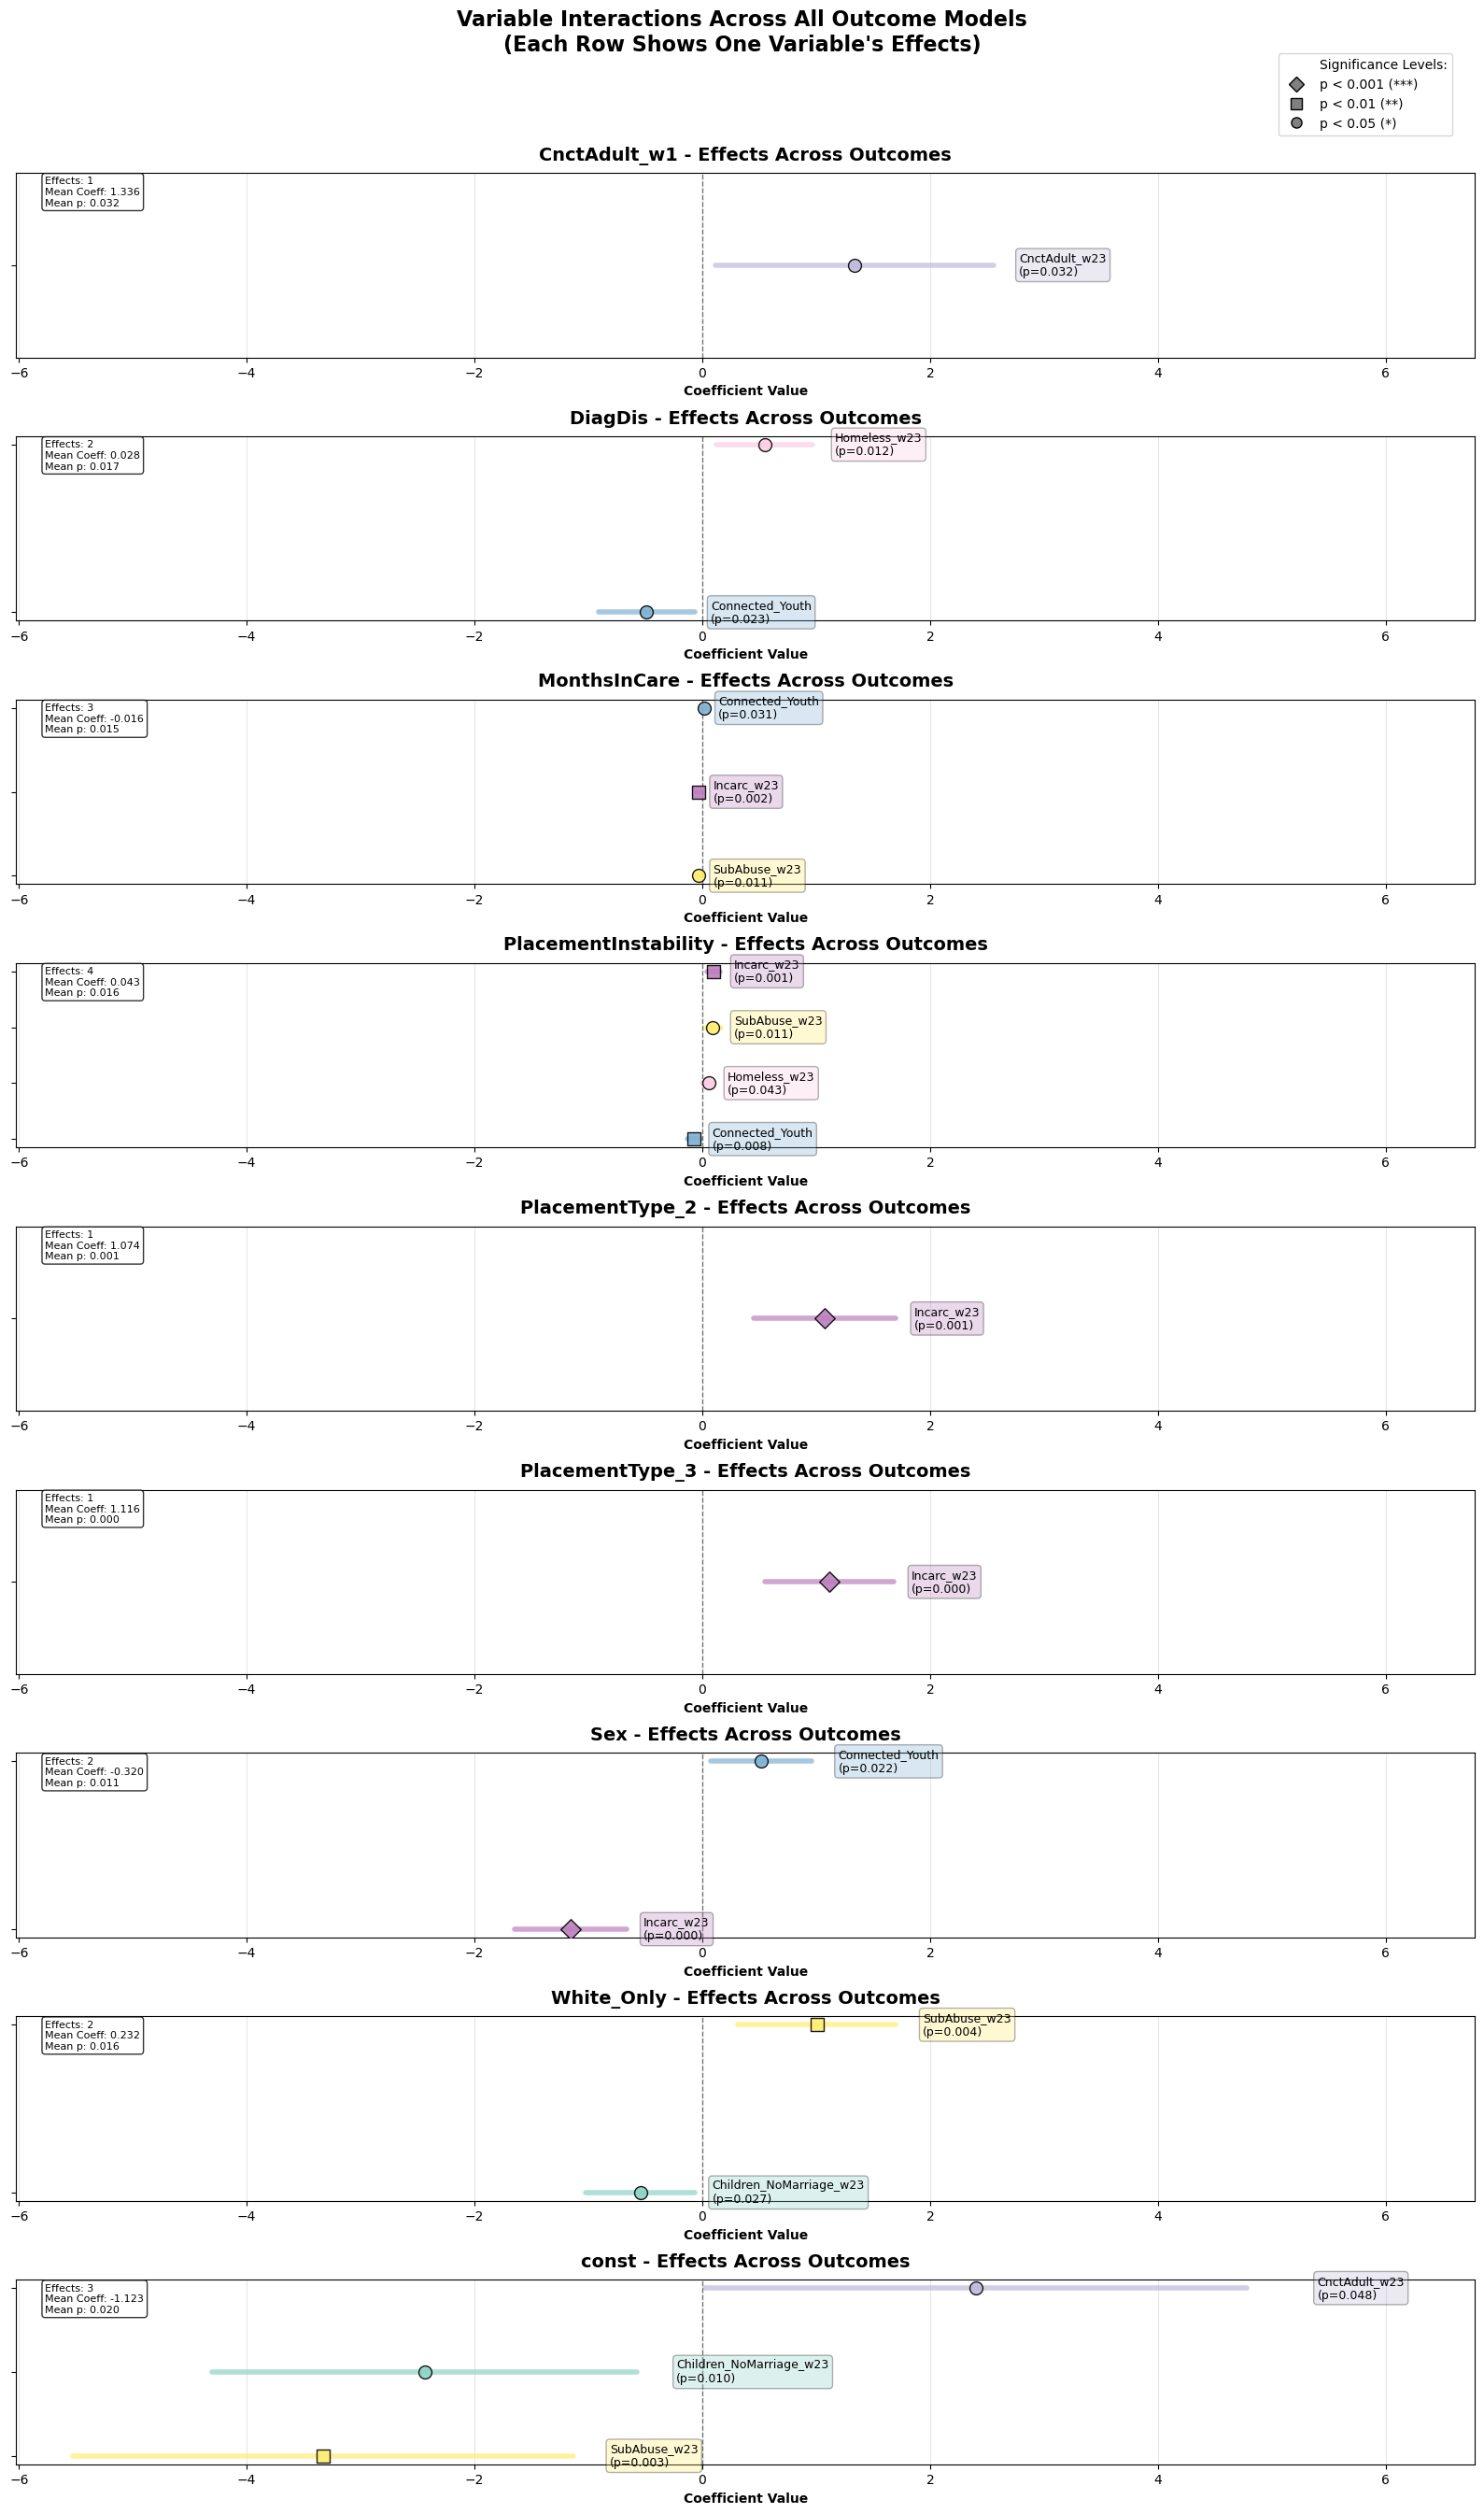

In [14]:
# Cell 2: Create Variable Interaction Matrix Visualization
def create_variable_interactions_plot():
    # Get unique variables and outcomes
    variables = sorted(df['Variable'].unique())
    outcomes = sorted(df['Outcome'].unique())
    
    # Create a figure with subplots - one row per variable
    fig, axes = plt.subplots(len(variables), 1, figsize=(16, 3*len(variables)))
    
    # If only one variable, make axes a list
    if len(variables) == 1:
        axes = [axes]
    
    # Color palette for outcomes
    outcome_colors = plt.cm.Set3(np.linspace(0, 1, len(outcomes)))
    outcome_color_map = dict(zip(outcomes, outcome_colors))
    
    for i, variable in enumerate(variables):
        ax = axes[i]
        
        # Get data for this variable
        var_data = df[df['Variable'] == variable].copy()
        
        if len(var_data) == 0:
            ax.text(0.5, 0.5, f'No data for {variable}', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{variable}', fontweight='bold', fontsize=12)
            continue
        
        # Sort by coefficient value for better visualization
        var_data = var_data.sort_values('Coefficient')
        
        # Create positions for each outcome
        y_positions = range(len(var_data))
        
        # Plot confidence intervals and coefficients
        for j, (idx, row) in enumerate(var_data.iterrows()):
            outcome = row['Outcome']
            color = outcome_color_map[outcome]
            
            # Plot confidence interval
            ax.plot([row['CI Lower'], row['CI Upper']], [j, j], 
                   color=color, linewidth=4, alpha=0.7, solid_capstyle='round')
            
            # Plot coefficient point
            marker_size = 100
            if row['P-Value'] < 0.001:
                marker = 'D'  # Diamond for highly significant
                marker_size = 120
            elif row['P-Value'] < 0.01:
                marker = 's'  # Square for very significant
                marker_size = 110
            else:
                marker = 'o'  # Circle for significant
                marker_size = 100
            
            ax.scatter(row['Coefficient'], j, 
                      color=color, s=marker_size, marker=marker, 
                      zorder=5, alpha=0.9, edgecolors='black', linewidth=1)
            
            # Add outcome label
            ax.text(max(row['CI Upper'], ax.get_xlim()[1] if ax.get_xlim()[1] != 1 else row['CI Upper']) + 0.1, 
                   j, f"{outcome}\n(p={row['P-Value']:.3f})", 
                   va='center', ha='left', fontsize=9, 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.3))
        
        # Add vertical line at zero
        ax.axvline(x=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
        
        # Customize axes
        ax.set_yticks(y_positions)
        ax.set_yticklabels([])  # Remove y-tick labels as we have outcome names
        ax.set_xlabel('Coefficient Value', fontweight='bold')
        ax.set_title(f'{variable} - Effects Across Outcomes', 
                    fontweight='bold', fontsize=14, pad=10)
        ax.grid(axis='x', alpha=0.3)
        
        # Set consistent x-axis limits across all subplots for comparison
        ax.set_xlim(df['CI Lower'].min() - 0.5, df['CI Upper'].max() + 2)
        
        # Add summary statistics in the corner
        n_effects = len(var_data)
        mean_coeff = var_data['Coefficient'].mean()
        mean_p = var_data['P-Value'].mean()
        
        summary_text = f'Effects: {n_effects}\nMean Coeff: {mean_coeff:.3f}\nMean p: {mean_p:.3f}'
        ax.text(0.02, 0.98, summary_text, transform=ax.transAxes, 
               va='top', ha='left', fontsize=8, 
               bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    
    # Create legend for significance levels
    legend_elements = [
        mpatches.Patch(color='none', label='Significance Levels:'),
        plt.Line2D([0], [0], marker='D', color='gray', linestyle='None',
                  markersize=8, label='p < 0.001 (***)', markeredgecolor='black'),
        plt.Line2D([0], [0], marker='s', color='gray', linestyle='None',
                  markersize=8, label='p < 0.01 (**)', markeredgecolor='black'),
        plt.Line2D([0], [0], marker='o', color='gray', linestyle='None',
                  markersize=8, label='p < 0.05 (*)', markeredgecolor='black')
    ]
    
    fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98))
    
    plt.suptitle('Variable Interactions Across All Outcome Models\n(Each Row Shows One Variable\'s Effects)', 
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

# Run the visualization
create_variable_interactions_plot()


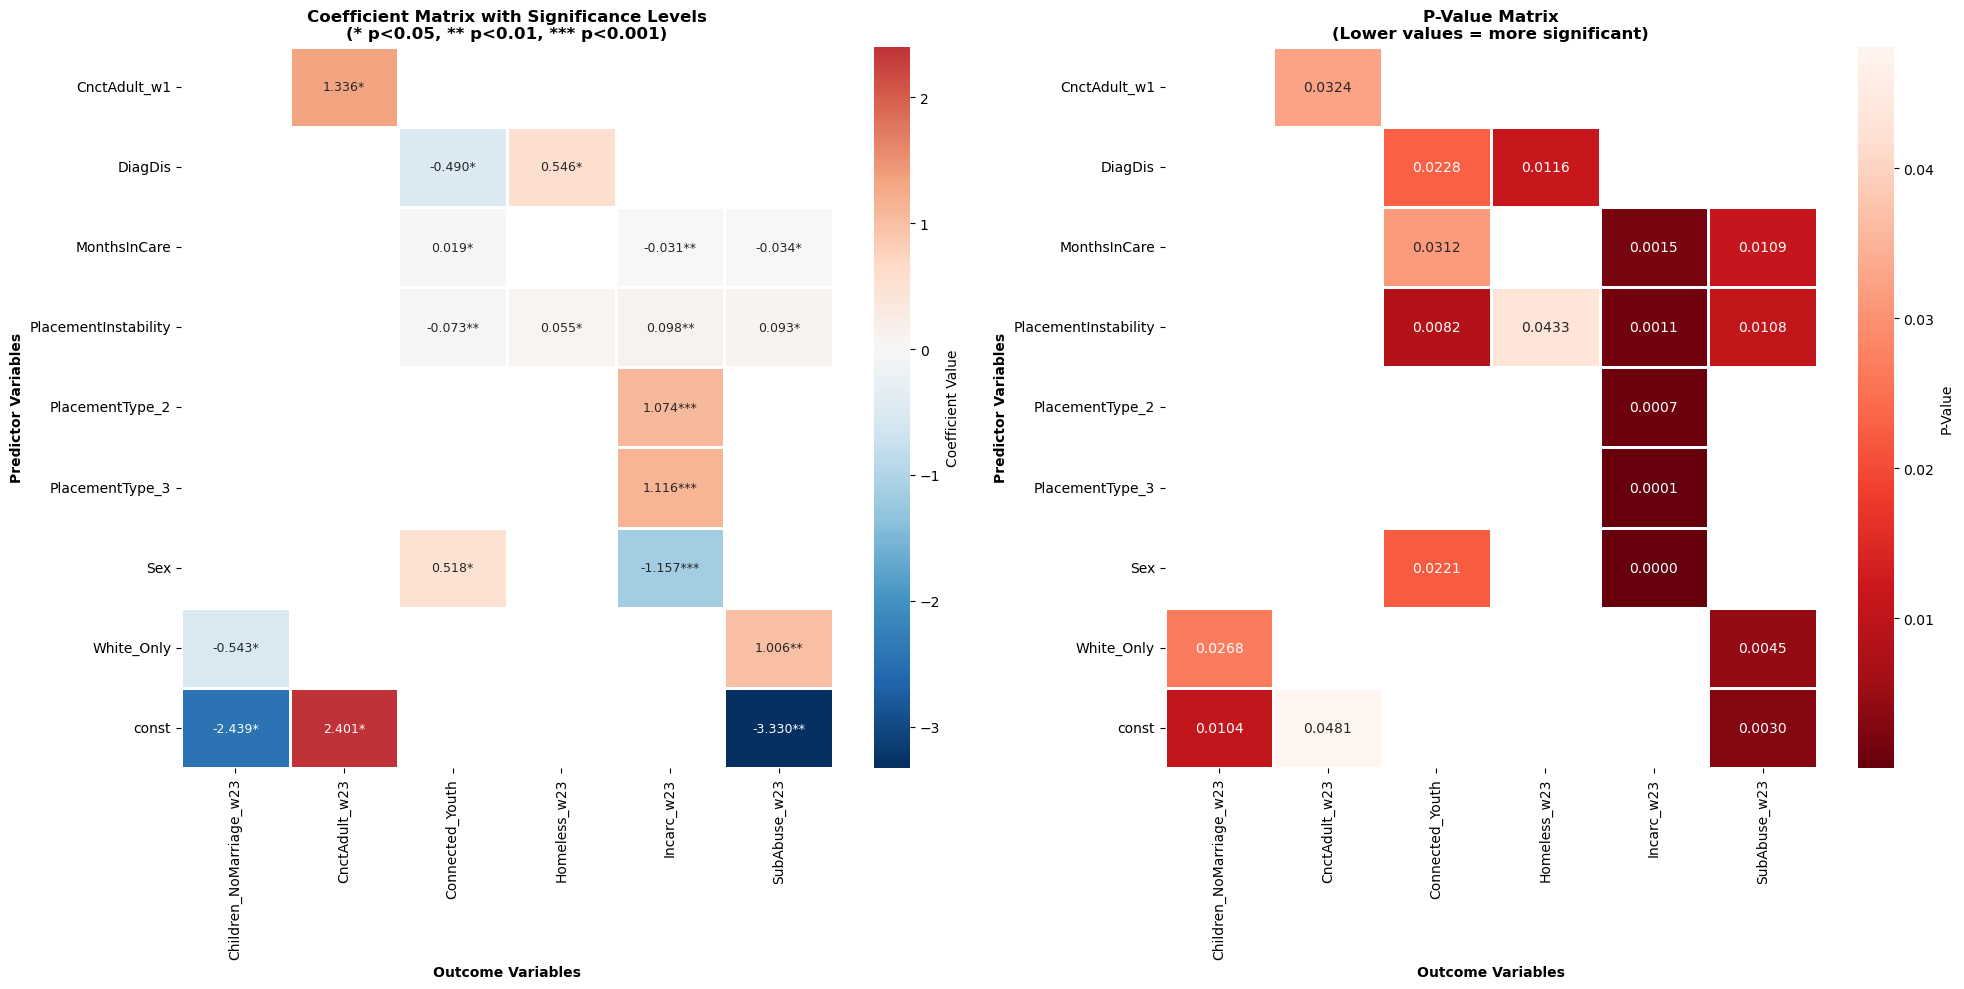

In [15]:
# ============================================================================

# Cell 3: Enhanced Variable-Outcome Matrix with Effect Sizes
def create_enhanced_variable_matrix():
    # Create pivot table for coefficients
    coeff_matrix = df.pivot(index='Variable', columns='Outcome', values='Coefficient')
    p_value_matrix = df.pivot(index='Variable', columns='Outcome', values='P-Value')
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Left plot: Coefficient heatmap with annotations
    mask = coeff_matrix.isnull()
    
    # Create custom annotations showing coefficient and significance
    annot_matrix = coeff_matrix.copy()
    for i in range(len(coeff_matrix.index)):
        for j in range(len(coeff_matrix.columns)):
            if not mask.iloc[i, j]:
                coeff_val = coeff_matrix.iloc[i, j]
                p_val = p_value_matrix.iloc[i, j]
                
                # Add significance stars
                if p_val < 0.001:
                    stars = '***'
                elif p_val < 0.01:
                    stars = '**'
                else:
                    stars = '*'
                
                annot_matrix.iloc[i, j] = f'{coeff_val:.3f}{stars}'
    
    sns.heatmap(coeff_matrix, 
               annot=annot_matrix, 
               fmt='', 
               cmap='RdBu_r', 
               center=0,
               mask=mask,
               cbar_kws={'label': 'Coefficient Value'},
               ax=ax1,
               linewidths=1,
               annot_kws={'fontsize': 9})
    
    ax1.set_title('Coefficient Matrix with Significance Levels\n(* p<0.05, ** p<0.01, *** p<0.001)', 
                 fontweight='bold', fontsize=12)
    ax1.set_xlabel('Outcome Variables', fontweight='bold')
    ax1.set_ylabel('Predictor Variables', fontweight='bold')
    
    # Right plot: P-value heatmap
    sns.heatmap(p_value_matrix, 
               annot=True, 
               fmt='.4f', 
               cmap='Reds_r', 
               mask=mask,
               cbar_kws={'label': 'P-Value'},
               ax=ax2,
               linewidths=1)
    
    ax2.set_title('P-Value Matrix\n(Lower values = more significant)', 
                 fontweight='bold', fontsize=12)
    ax2.set_xlabel('Outcome Variables', fontweight='bold')
    ax2.set_ylabel('Predictor Variables', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

create_enhanced_variable_matrix()

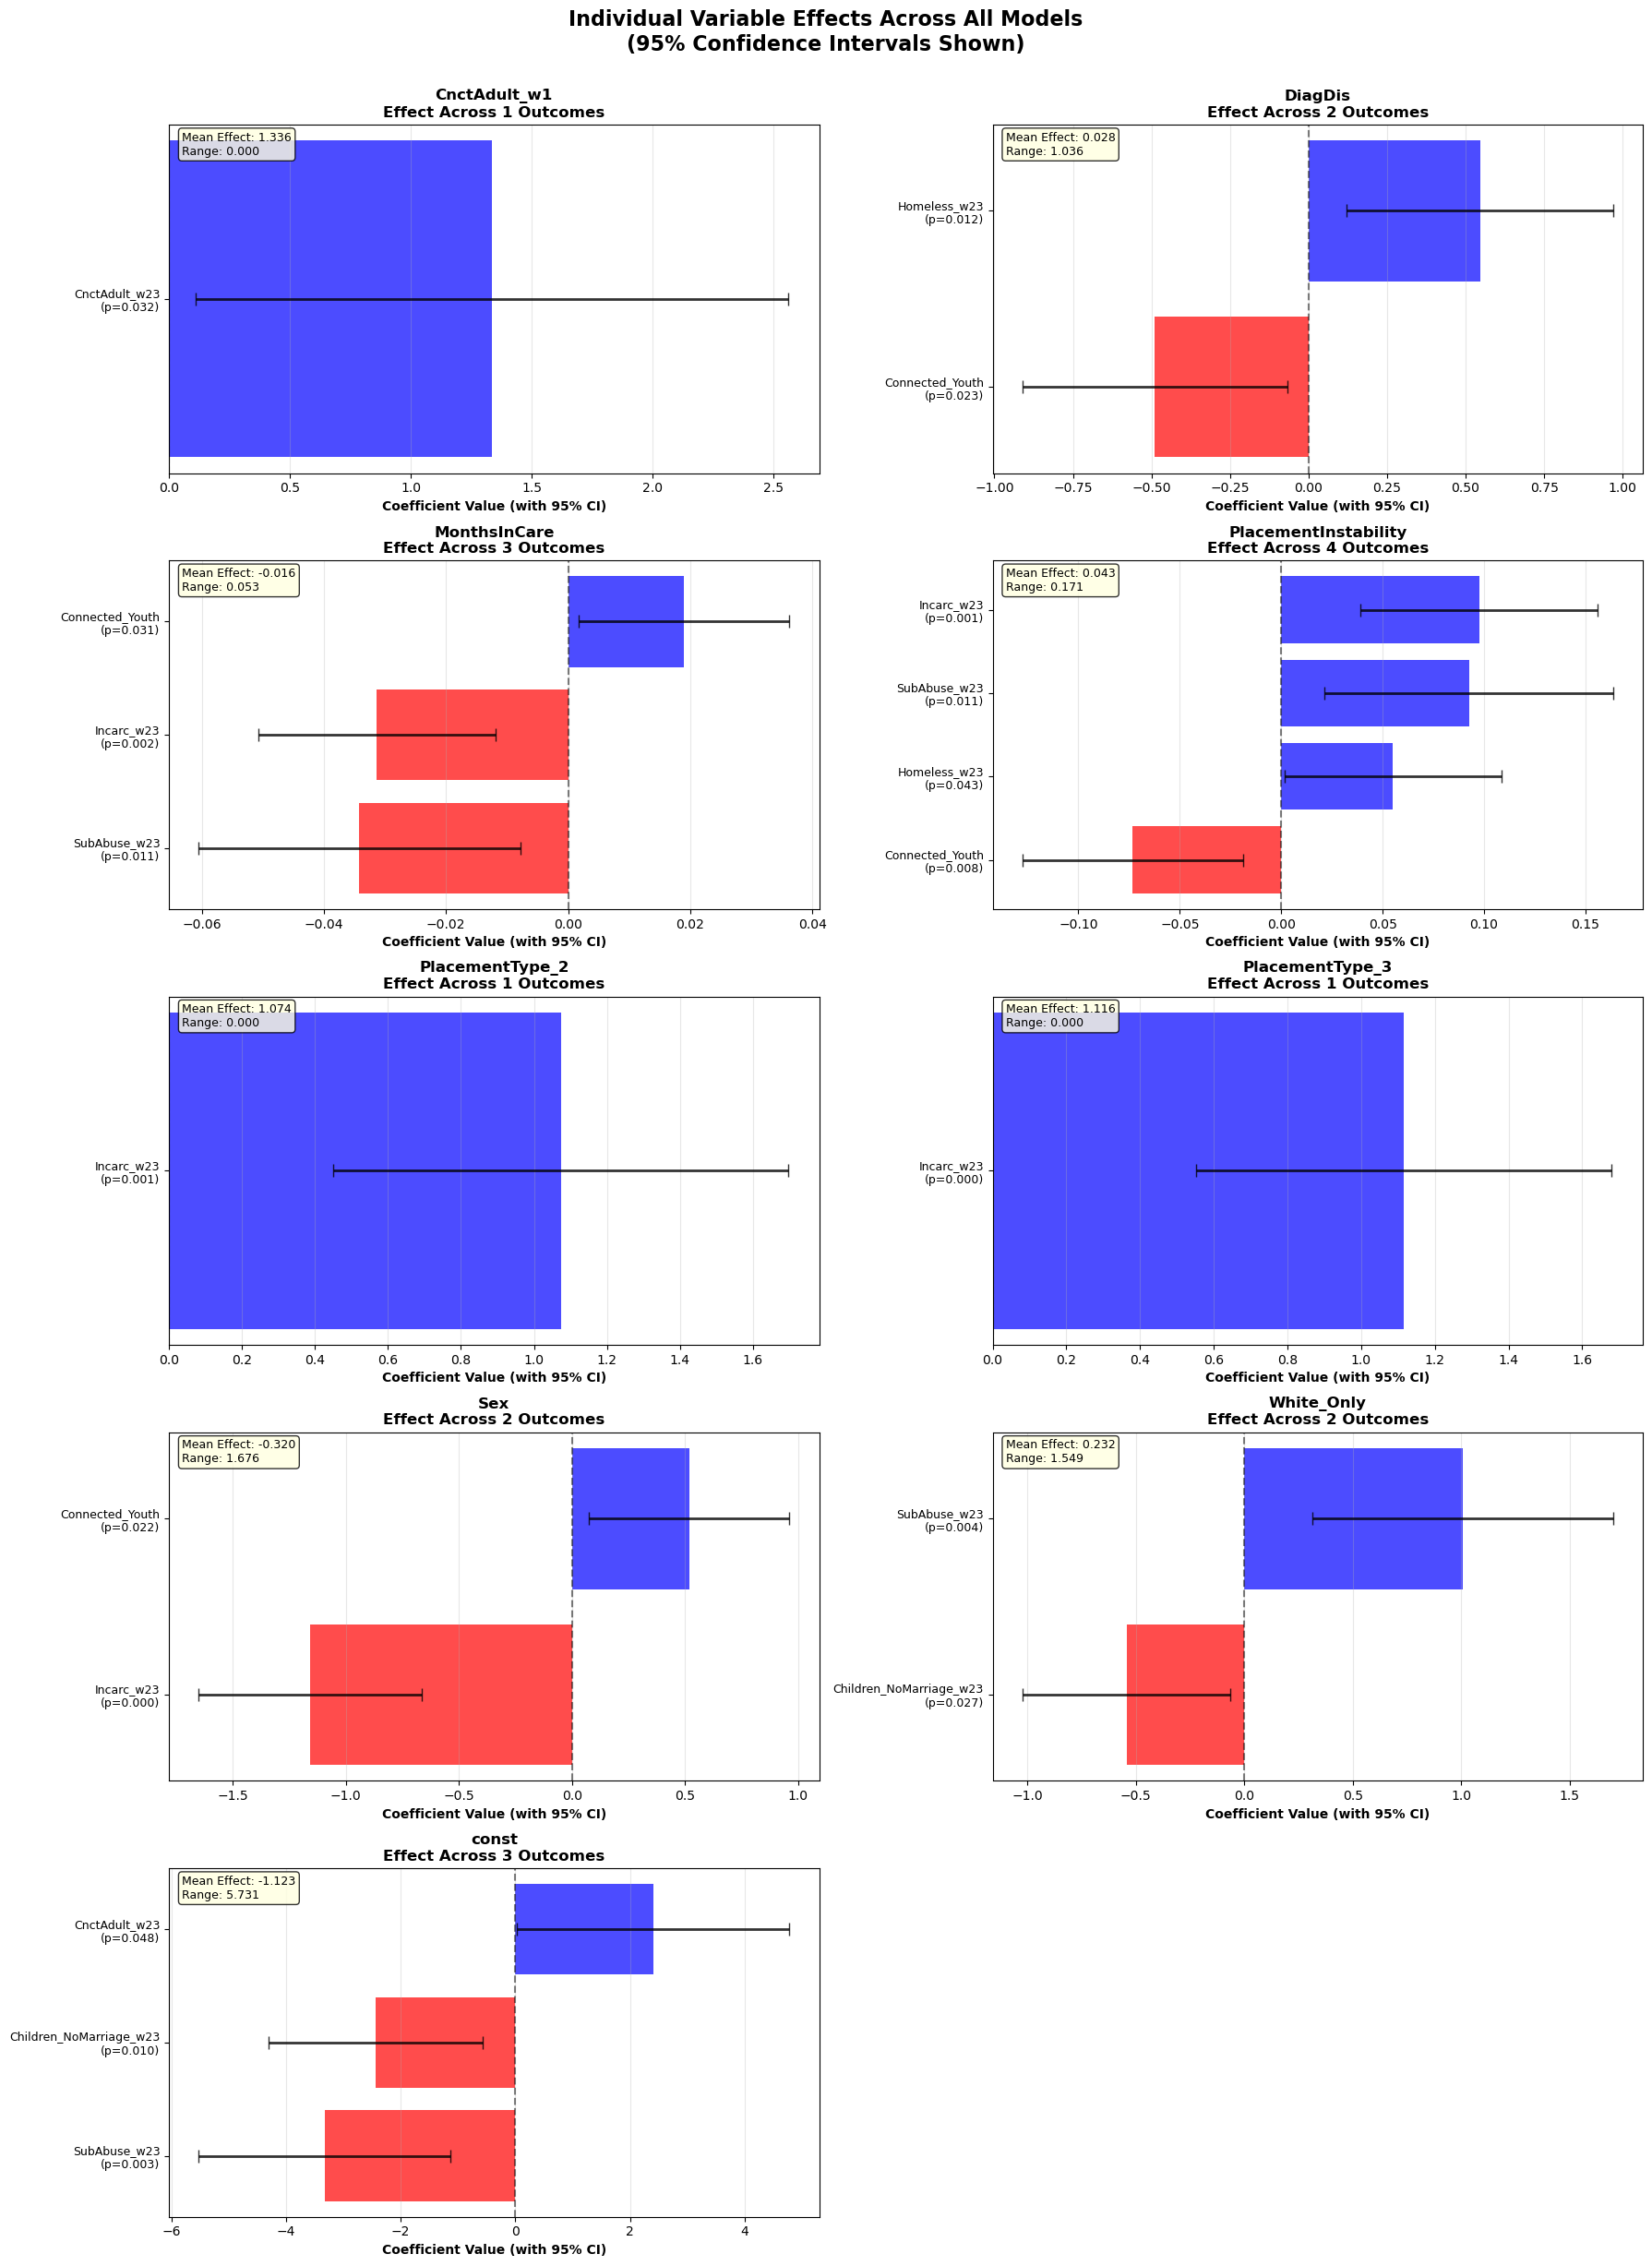

In [16]:
# Cell 4: Individual Variable Deep Dive Plots
def create_individual_variable_plots():
    variables = sorted(df['Variable'].unique())
    
    # Calculate number of rows needed (2 plots per row)
    n_rows = (len(variables) + 1) // 2
    
    fig, axes = plt.subplots(n_rows, 2, figsize=(18, 5*n_rows))
    
    # Flatten axes if multiple rows
    if n_rows > 1:
        axes = axes.flatten()
    elif n_rows == 1:
        axes = [axes[0], axes[1]]
    
    for i, variable in enumerate(variables):
        if i >= len(axes):
            break
            
        ax = axes[i]
        var_data = df[df['Variable'] == variable].copy()
        
        if len(var_data) == 0:
            ax.text(0.5, 0.5, f'No data for {variable}', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{variable}', fontweight='bold')
            continue
        
        # Sort by coefficient for better visualization
        var_data = var_data.sort_values('Coefficient')
        
        # Create horizontal bar plot with error bars
        y_pos = range(len(var_data))
        coeffs = var_data['Coefficient'].values
        
        # Calculate error bar lengths
        lower_errors = coeffs - var_data['CI Lower'].values
        upper_errors = var_data['CI Upper'].values - coeffs
        
        # Color bars by direction
        colors = ['red' if x < 0 else 'blue' for x in coeffs]
        
        # Create bars
        bars = ax.barh(y_pos, coeffs, color=colors, alpha=0.7, 
                      xerr=[lower_errors, upper_errors], 
                      capsize=5, error_kw={'linewidth': 2, 'alpha': 0.8})
        
        # Add outcome labels
        ax.set_yticks(y_pos)
        ax.set_yticklabels([f"{row['Outcome']}\n(p={row['P-Value']:.3f})" 
                           for _, row in var_data.iterrows()], fontsize=9)
        
        # Add vertical line at zero
        ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
        
        # Customize
        ax.set_xlabel('Coefficient Value (with 95% CI)', fontweight='bold')
        ax.set_title(f'{variable}\nEffect Across {len(var_data)} Outcomes', 
                    fontweight='bold', fontsize=12)
        ax.grid(axis='x', alpha=0.3)
        
        # Add effect size summary
        mean_effect = var_data['Coefficient'].mean()
        effect_range = var_data['Coefficient'].max() - var_data['Coefficient'].min()
        
        ax.text(0.02, 0.98, f'Mean Effect: {mean_effect:.3f}\nRange: {effect_range:.3f}', 
               transform=ax.transAxes, va='top', ha='left', fontsize=9,
               bbox=dict(boxstyle="round,pad=0.3", facecolor='lightyellow', alpha=0.8))
    
    # Hide empty subplots
    for i in range(len(variables), len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle('Individual Variable Effects Across All Models\n(95% Confidence Intervals Shown)', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

create_individual_variable_plots()

In [17]:
# Cell 5: Variable Interaction Summary Table and Statistics
def create_summary_analysis():
    print("="*100)
    print("VARIABLE INTERACTION ANALYSIS SUMMARY")
    print("="*100)
    
    variables = sorted(df['Variable'].unique())
    
    for variable in variables:
        var_data = df[df['Variable'] == variable].copy()
        
        print(f"\n📊 {variable.upper()}")
        print("-" * 60)
        print(f"Number of outcomes affected: {len(var_data)}")
        print(f"Outcomes: {', '.join(var_data['Outcome'].tolist())}")
        
        # Effect statistics
        mean_coeff = var_data['Coefficient'].mean()
        min_coeff = var_data['Coefficient'].min()
        max_coeff = var_data['Coefficient'].max()
        
        print(f"\nEffect Statistics:")
        print(f"  • Mean coefficient: {mean_coeff:.4f}")
        print(f"  • Range: {min_coeff:.4f} to {max_coeff:.4f}")
        print(f"  • Effect direction: ", end="")
        
        positive_effects = (var_data['Coefficient'] > 0).sum()
        negative_effects = (var_data['Coefficient'] < 0).sum()
        
        if positive_effects > negative_effects:
            print(f"Predominantly POSITIVE ({positive_effects} pos, {negative_effects} neg)")
        elif negative_effects > positive_effects:
            print(f"Predominantly NEGATIVE ({negative_effects} neg, {positive_effects} pos)")
        else:
            print(f"MIXED ({positive_effects} pos, {negative_effects} neg)")
        
        # Significance statistics
        mean_p = var_data['P-Value'].mean()
        highly_sig = (var_data['P-Value'] < 0.001).sum()
        very_sig = (var_data['P-Value'] < 0.01).sum()
        
        print(f"\nSignificance Profile:")
        print(f"  • Mean p-value: {mean_p:.6f}")
        print(f"  • Highly significant (p<0.001): {highly_sig}")
        print(f"  • Very significant (p<0.01): {very_sig}")
        print(f"  • All significant (p<0.05): {len(var_data)}")
        
        # Confidence interval analysis
        mean_ci_width = (var_data['CI Upper'] - var_data['CI Lower']).mean()
        print(f"  • Mean CI width: {mean_ci_width:.4f}")
        
        # Most impactful outcome
        strongest_effect_idx = var_data['Coefficient'].abs().idxmax()
        strongest_outcome = var_data.loc[strongest_effect_idx, 'Outcome']
        strongest_coeff = var_data.loc[strongest_effect_idx, 'Coefficient']
        strongest_p = var_data.loc[strongest_effect_idx, 'P-Value']
        
        print(f"\nStrongest Effect:")
        print(f"  • Outcome: {strongest_outcome}")
        print(f"  • Coefficient: {strongest_coeff:.4f}")
        print(f"  • P-value: {strongest_p:.6f}")
    
    # Overall interaction patterns
    print(f"\n" + "="*100)
    print("OVERALL INTERACTION PATTERNS")
    print("="*100)
    
    # Variables appearing in multiple models
    var_frequency = df['Variable'].value_counts()
    multi_model_vars = var_frequency[var_frequency > 1]
    
    print(f"\nVariables appearing in multiple models:")
    for var, count in multi_model_vars.items():
        print(f"  • {var}: {count} models")
    
    # Most consistent effect directions
    print(f"\nEffect direction consistency:")
    for variable in variables:
        var_data = df[df['Variable'] == variable]
        if len(var_data) > 1:
            all_positive = (var_data['Coefficient'] > 0).all()
            all_negative = (var_data['Coefficient'] < 0).all()
            
            if all_positive:
                print(f"  • {variable}: Consistently POSITIVE across all models")
            elif all_negative:
                print(f"  • {variable}: Consistently NEGATIVE across all models")
            else:
                pos_count = (var_data['Coefficient'] > 0).sum()
                neg_count = (var_data['Coefficient'] < 0).sum()
                print(f"  • {variable}: Mixed effects ({pos_count} pos, {neg_count} neg)")

create_summary_analysis()

VARIABLE INTERACTION ANALYSIS SUMMARY

📊 CNCTADULT_W1
------------------------------------------------------------
Number of outcomes affected: 1
Outcomes: CnctAdult_w23

Effect Statistics:
  • Mean coefficient: 1.3358
  • Range: 1.3358 to 1.3358
  • Effect direction: Predominantly POSITIVE (1 pos, 0 neg)

Significance Profile:
  • Mean p-value: 0.032398
  • Highly significant (p<0.001): 0
  • Very significant (p<0.01): 0
  • All significant (p<0.05): 1
  • Mean CI width: 2.4475

Strongest Effect:
  • Outcome: CnctAdult_w23
  • Coefficient: 1.3358
  • P-value: 0.032398

📊 DIAGDIS
------------------------------------------------------------
Number of outcomes affected: 2
Outcomes: Connected_Youth, Homeless_w23

Effect Statistics:
  • Mean coefficient: 0.0282
  • Range: -0.4898 to 0.5461
  • Effect direction: MIXED (1 pos, 1 neg)

Significance Profile:
  • Mean p-value: 0.017185
  • Highly significant (p<0.001): 0
  • Very significant (p<0.01): 0
  • All significant (p<0.05): 2
  • Mean 

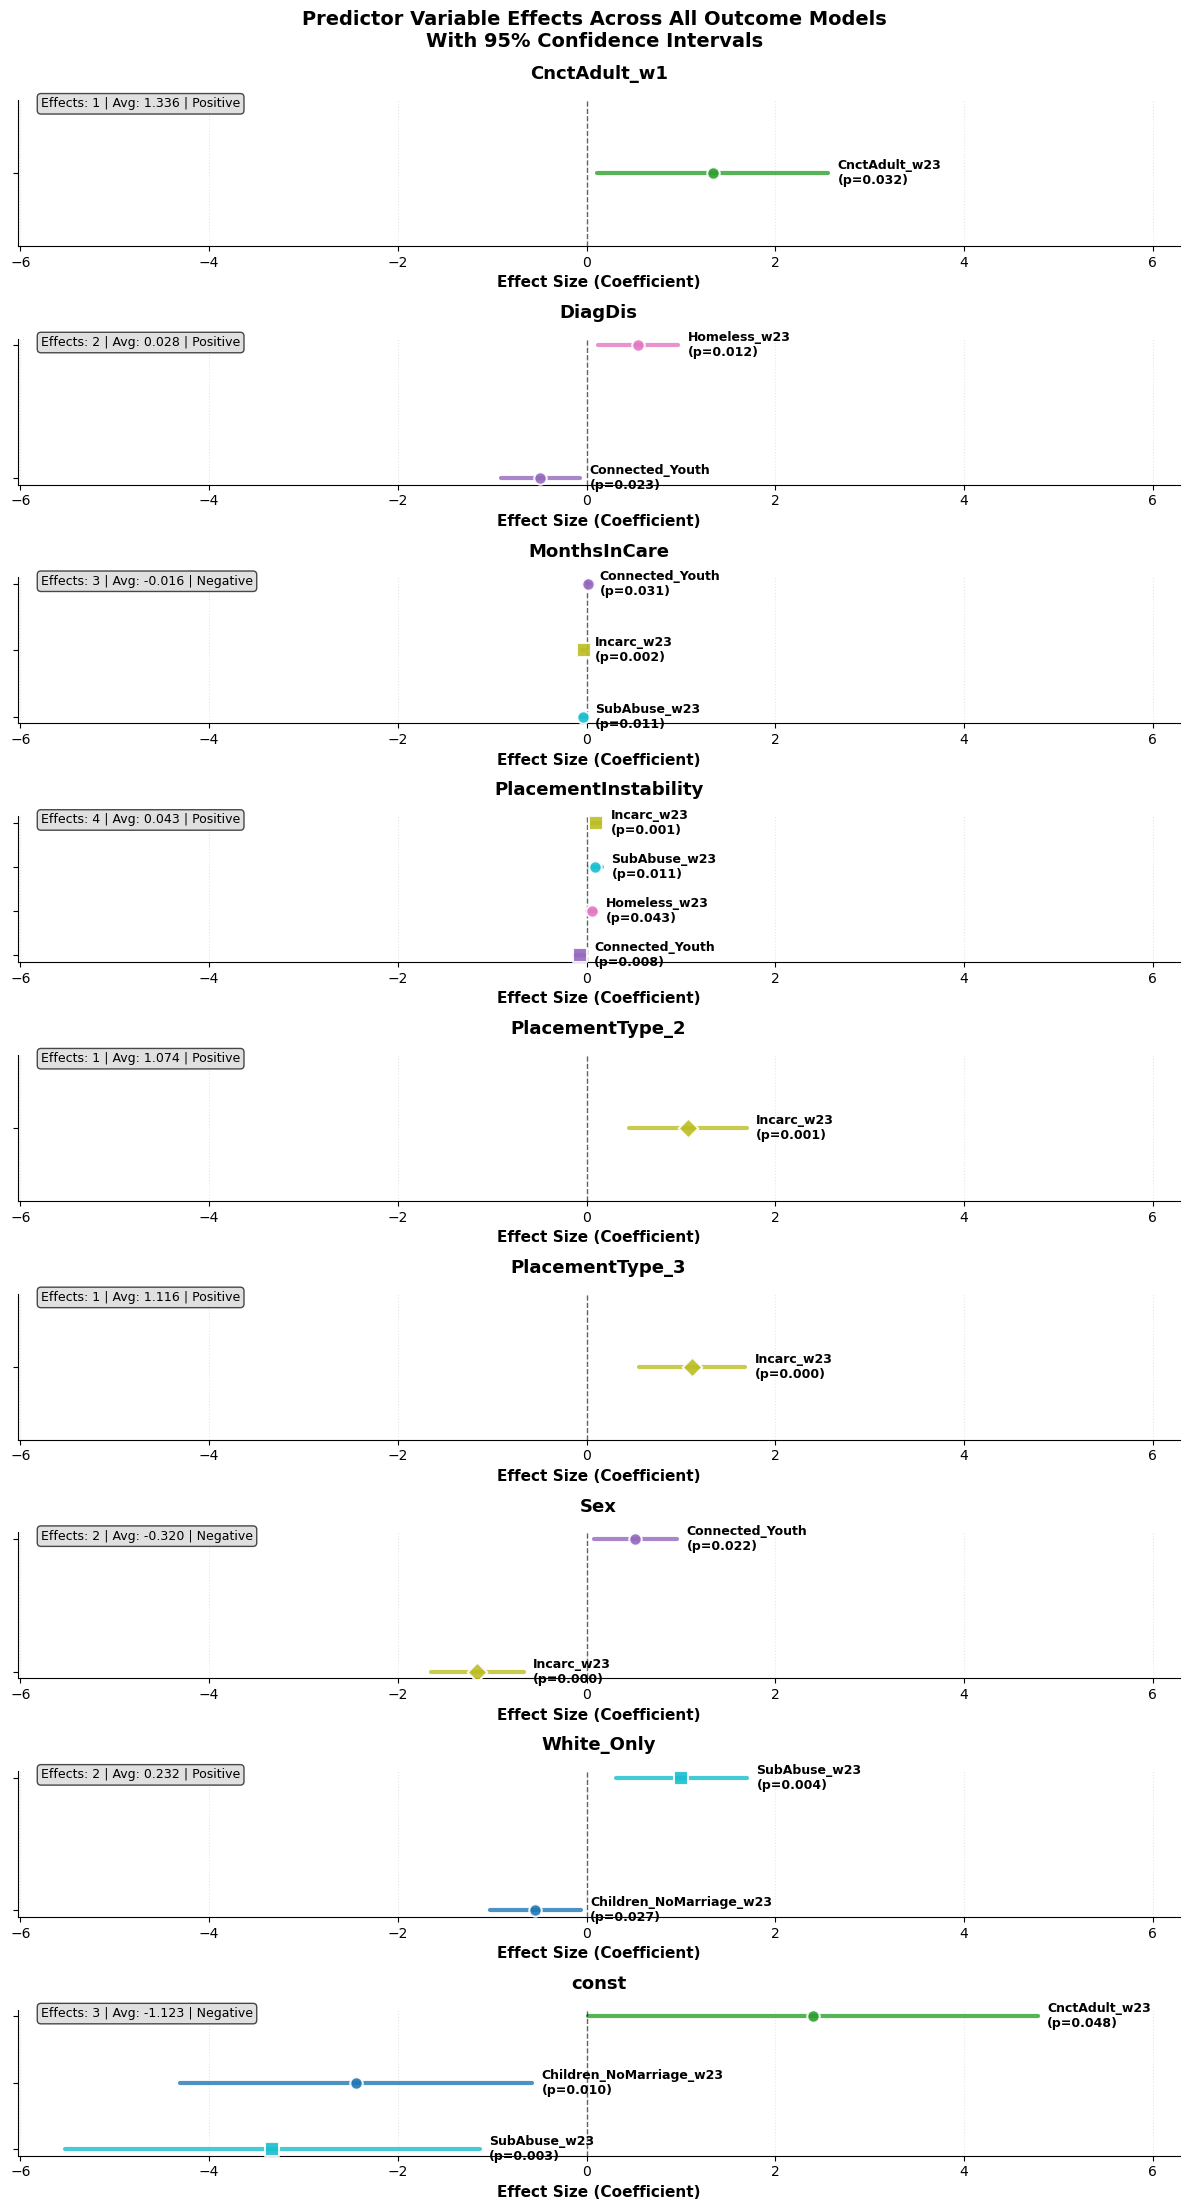


✅ All variable interaction visualizations completed!
Each visualization shows how individual predictors affect different outcomes.


In [18]:
# Cell 6: Create Publication-Ready Variable Effects Plot
def create_publication_plot():
    # Set publication style
    plt.style.use('default')
    sns.set_palette("husl")
    
    variables = sorted(df['Variable'].unique())
    n_vars = len(variables)
    
    # Create figure with proper spacing
    fig, axes = plt.subplots(n_vars, 1, figsize=(12, 2.5*n_vars))
    
    if n_vars == 1:
        axes = [axes]
    
    # Define consistent colors for outcomes
    outcomes = sorted(df['Outcome'].unique())
    colors = plt.cm.tab10(np.linspace(0, 1, len(outcomes)))
    outcome_colors = dict(zip(outcomes, colors))
    
    for i, variable in enumerate(variables):
        ax = axes[i]
        var_data = df[df['Variable'] == variable].copy().sort_values('Coefficient')
        
        # Plot each effect
        for j, (_, row) in enumerate(var_data.iterrows()):
            outcome = row['Outcome']
            coeff = row['Coefficient']
            ci_lower = row['CI Lower']
            ci_upper = row['CI Upper']
            p_val = row['P-Value']
            
            color = outcome_colors[outcome]
            
            # Plot CI line
            ax.plot([ci_lower, ci_upper], [j, j], 
                   color=color, linewidth=3, alpha=0.8, solid_capstyle='round')
            
            # Plot coefficient point
            marker_size = 80
            if p_val < 0.001:
                marker = 'D'
                marker_size = 100
            elif p_val < 0.01:
                marker = 's'
                marker_size = 90
            else:
                marker = 'o'
                marker_size = 80
            
            ax.scatter(coeff, j, color=color, s=marker_size, marker=marker,
                      zorder=10, edgecolors='white', linewidth=1.5, alpha=0.9)
            
            # Add outcome label with p-value
            label_text = f"{outcome}\n(p={p_val:.3f})"
            ax.text(ci_upper + 0.1, j, label_text, va='center', ha='left', 
                   fontsize=9, weight='bold')
        
        # Zero line
        ax.axvline(x=0, color='black', linestyle='--', alpha=0.6, linewidth=1)
        
        # Formatting
        ax.set_yticks(range(len(var_data)))
        ax.set_yticklabels([])
        ax.set_xlabel('Effect Size (Coefficient)', fontweight='bold', fontsize=11)
        ax.set_title(f'{variable}', fontweight='bold', fontsize=13, pad=15)
        ax.grid(axis='x', alpha=0.3, linestyle=':')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Set consistent x-limits
        all_lower = df['CI Lower'].min()
        all_upper = df['CI Upper'].max()
        ax.set_xlim(all_lower - 0.5, all_upper + 1.5)
        
        # Add variable summary
        n_effects = len(var_data)
        mean_coeff = var_data['Coefficient'].mean()
        direction = "Positive" if mean_coeff > 0 else "Negative"
        
        summary = f"Effects: {n_effects} | Avg: {mean_coeff:.3f} | {direction}"
        ax.text(0.02, 0.95, summary, transform=ax.transAxes, 
               fontsize=9, bbox=dict(boxstyle="round,pad=0.3", 
               facecolor='lightgray', alpha=0.7))
    
    plt.suptitle('Predictor Variable Effects Across All Outcome Models\nWith 95% Confidence Intervals', 
                fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    plt.show()

create_publication_plot()

print("\n✅ All variable interaction visualizations completed!")
print("Each visualization shows how individual predictors affect different outcomes.")